### Pour aller plus loin avec le SQL distribué

Nous avons vu précédemment que l'on pouvait via Spark SQL accéder à des données distribuées stockées sous forme de fichier en les rêquetant avec du SQL standard.

Pour cela, Spark traduit la requête SQL à éxecuter dans un plan d'éxécution et bien souvent :
1. Ramène sur les executeurs Spark les données du fichier.
2. Définit les traitements qu'il va faire sur les RDD pour arriver aux résultats.
3. Ramène le résultat sur le client, dans notre cas Jupyter.

Pour avoir de bonnes performances, et d'autant plus que les executeurs Spark et les données ne sont pas sur les mêmes machines, il est donc utile de :
1. Avoir des données compressées qui transitent plus vite sur le réseau.
2. Avoir des mécanismes intelligents qui fitrent les données pour ne ramener sur les executeurs que les données réellement nécessaires.

Pour cela, il existe différents formats de fichier, et si csv est l'un des plus répandus, ce n'est pas forcément le plus optimal.
Nous allons ici vous présenter le format parquet qui est un format compressé, orienté colonne, avec des mécanismes de filtrage qui optimisent le transit de l'information réellement utile sur les executeurs.

In [30]:
import os
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         # url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster 
         # (ici le notebook tourne lui même dans kubernetes)
         .master("k8s://https://kubernetes.default.svc:443")
         # Nom du pod qui exécute le driver
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         # image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Nom du namespace kubernetes
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
         .config("spark.executor.instances", "5")
         # Mémoire alloué à la JVM
         # Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
         # On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
         .config("spark.executor.memory", "4g")
         .getOrCreate()
        )

sc = spark.sparkContext

2022-03-29 10:16:28,025 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-03-29 10:16:28,183 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [31]:
import os
import s3fs
import json

from pyspark.sql.types import StructType

endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
    a = f.read()
    schema = StructType.fromJson(json.loads(a))

df = (spark.read
      .format("csv")
      .options(header='true', inferschema='false', delimiter=',')
      .schema(schema)
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )
df.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

#### Requete sur le csv

Nous allons faire 3 requetes sur cette table appelée sirene.

1. Un count du nombre de lignes
2. Un extrait de 10 lignes
3. Un comptages du top 10 des code activitePrincipalEtablissement.

On va afficher le temps d'execution.

In [32]:
df.createOrReplaceTempView("sirene")

dfCount = spark.sql("SELECT * FROM sirene LIMIT 10")
dfGroupBy= spark.sql("SELECT count(*) as tot , activitePrincipaleEtablissement FROM sirene group by activitePrincipaleEtablissement order by tot desc LIMIT 10")
%time print('comptage total : {}'.format(df.count()))
%time print('comptage des 10 premières lignes : {}'.format(dfCount.count()))
%time dfGroupBy.show()

comptage total : 69911542
CPU times: user 40.2 ms, sys: 10.2 ms, total: 50.4 ms
Wall time: 18.1 s


comptage des 10 premières lignes : 10
CPU times: user 7.6 ms, sys: 294 µs, total: 7.89 ms
Wall time: 1.71 s


+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 37.2 ms, sys: 15.7 ms, total: 52.9 ms
Wall time: 19.7 s


#### Le plan suivi par spark pour le groupby

1. Spark a lu tout le fichier en 53 étapes pour chaque étape il a calculé le nombre d'établissement par codeApe.
2. Il a mis ce résultat en commun pour aggréger
3. Il a ramené sur le client le top10

Le shuffle indique généralement des échanges sur le réseau entre executor spark, plus il y a de shuffle moins on est content généralement.
Quand on ne peut l'éviter, on souhaite qu'il concerne le moins de donnée possible, ici, ca va, le shuffle concerne un code de nomenclature et un total.

(les temps d'execution ne sont peut etre pas les memes selon la configuration de votre spark)

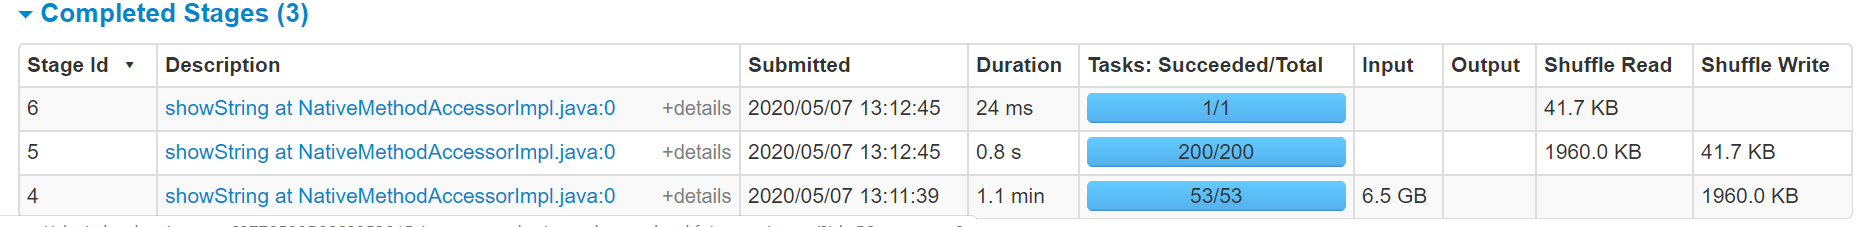

#### Comparaison avec les mêmes données au format parquet

Le dataframe issu du csv a été enregistré au format parquet avec la commande suivante
```
df.write.mode('append').parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
```

Nous allons avec le sqlContext de Spark refaire exactement la même chose que précédemment.
1. Demander de lire le fichier en découvrant seul le schéma.
2. Donner le résultat des 3 mêmes requetes.

Remarquez qu'une fois le dataFrame lu, les syntaxes sont exactement les mêmes.



In [33]:
#df.write.mode('append').parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")

In [34]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/sirene.parquet

[2022-02-10 21:46:58 UTC]     0B _SUCCESS
[2022-02-10 21:46:58 UTC]  15MiB part-00000-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:58 UTC]  15MiB part-00001-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  16MiB part-00002-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  16MiB part-00003-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  16MiB part-00004-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  16MiB part-00005-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  16MiB part-00006-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:46:59 UTC]  15MiB part-00007-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:47:00 UTC]  15MiB part-00008-1ec61661-25a7-4831-8310-77c969944391-c000.snappy.parquet
[2022-02-10 21:47:00 UTC]  15MiB part-00009-1ec61

Vos pouvez remarquer que 53 fichiers ont écrit sur le stockage. Cela correspond exactement exactement au nombre de partition du dataframe original. En effet spark dans sa configuration par défaut travaille sur 128 Mo de données et a donc découper le job sur les 6,5 Go en 53 taches qui chacune va écrire l'output dans un nouveau fichier.

In [35]:
parquetDf = spark.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
parquetDf.createOrReplaceTempView("sireneparquet")
parquetDfCount = spark.sql("SELECT * FROM sireneparquet LIMIT 10")
parquetDFGroupBy= spark.sql("SELECT count(*) as tot , activitePrincipaleEtablissement FROM sireneparquet group by activitePrincipaleEtablissement order by tot desc LIMIT 10")
%time print('comptage total : {}'.format(parquetDf.count()))
%time print('comptage des 10 premières lignes : {}'.format(parquetDfCount.count()))
%time parquetDFGroupBy.show()

comptage total : 69911542
CPU times: user 6.26 ms, sys: 1.94 ms, total: 8.2 ms
Wall time: 2.41 s


comptage des 10 premières lignes : 10
CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 979 ms


+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 4.17 s


#### Le plan suivi par spark pour le groupby

En parquet, pour le même group by il y a un gain important de performance, l'essentiel du temps est gagné du fait que le format est optimisé pour ne faire passer sur le réseau vers les executors que les données de la colonne concernée.
On passe de 6Go de données brassées à quelques Mo.

De plus le fichier parquet logique a été écrit en 53 sous fichiers (hérités des 53 partitions du csv).
Mais comme les fichiers sont compressés en parquet il n'y a que 9 blocs de lus au lieu de 53.

Une fois la lecture faite des fichiers on retrouve la seconde étape avec 200 partitions, c'est la valeur par défaut dans spark que l'on retrouve dans l'execution csv quand il doit restructurer son rdd sur le réseau.

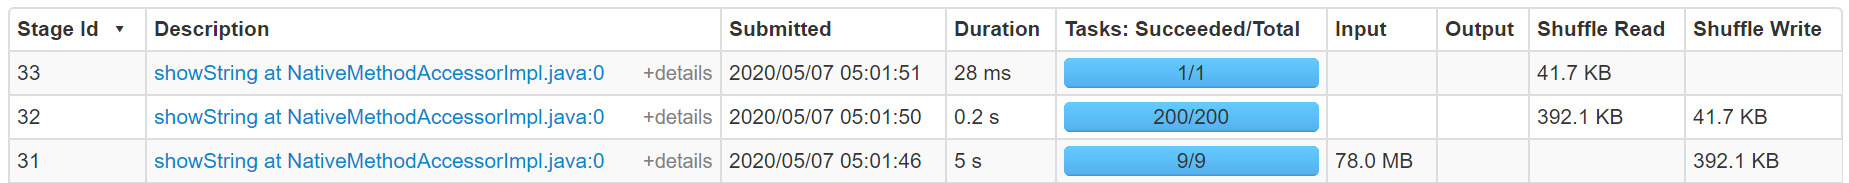

#### amélioration possible

Le dataframe issu du csv a été enregistré au format parquet en regardant la structure du fichier enregistré on 
on a hérité ca lors de l'écriture.

Parquet ou non, on peut forcer l'écriture dans un fichier  en réorganisant le partitionnement du rdd avant l'écriture :
On peut par exemple chercher à avoir des fichiers de 128 Mo environ pour lire un seul fichier par tache.
La tache de repartition est assez couteuse et nous sommes obligés d'augmentant les limites de mémoire du container pour éviter les erreurs.
```
config("spark.kubernetes.memoryOverheadFactor", "0.5")
parquetDf.repartition(10).write.mode('overwrite').parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet")
```

Tant qu'on y est changeons le niveau de parallélisme lors du shuffle de spark qui est par défaut à 200.
```
config("spark.sql.shuffle.partitions", "5")
config("spark.default.parallelism", "5")
```


In [36]:
spark.stop()
spark = (SparkSession 
         .builder
         # url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster 
         # (ici le notebook tourne lui même dans kubernetes)
         .master("k8s://https://kubernetes.default.svc:443")
         # Nom du pod qui exécute le driver
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         # image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Nom du namespace kubernetes
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Nombre d'executeur spark, il se lancera autant de pods kubernetes que le nombre indiqué.
         .config("spark.executor.instances", "5")
         .config("spark.sql.shuffle.partitions", "5")
         .config("spark.default.parallelism", "5")
         .config("spark.kubernetes.memoryOverheadFactor", "0.5")
         # Mémoire alloué à la JVM
         # Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
         # On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
         .config("spark.executor.memory", "4g")
         .getOrCreate()
        )

2022-03-29 10:17:25,470 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
2022-03-29 10:17:26,039 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-03-29 10:17:26,185 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [37]:
parquetDf = spark.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")

In [38]:
#parquetDf.repartition(10).write.mode('overwrite').parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet")

In [39]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet

[2022-02-10 21:46:27 UTC]     0B _SUCCESS
[2022-02-10 21:46:46 UTC] 138MiB part-00000-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:48 UTC] 139MiB part-00001-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:45 UTC] 139MiB part-00002-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:47 UTC] 138MiB part-00003-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:56 UTC] 138MiB part-00004-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:47:50 UTC] 138MiB part-00005-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:59 UTC] 139MiB part-00006-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:47:01 UTC] 140MiB part-00007-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:47:50 UTC] 139MiB part-00008-bf5da419-f39f-43e0-9a33-485588cfae04-c000.snappy.parquet
[2022-02-10 21:46:57 UTC] 138MiB part-00009-bf5da

In [40]:
tenParquetDf = spark.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet")
tenParquetDf.createOrReplaceTempView("sirene10")
tenParquetDfCount = spark.sql("SELECT * FROM sirene10 LIMIT 10")
tenParquetDfGroupBy= spark.sql("SELECT count(*) as tot , activitePrincipaleEtablissement FROM sirene10 group by activitePrincipaleEtablissement order by tot desc LIMIT 10")
%time print('comptage total : {}'.format(tenParquetDf.count()))
%time print('comptage des 10 premières lignes : {}'.format(tenParquetDfCount.count()))
%time tenParquetDfGroupBy.show()

comptage total : 69911542
CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 3.9 s


comptage des 10 premières lignes : 10
CPU times: user 4.3 ms, sys: 21 µs, total: 4.33 ms
Wall time: 894 ms


+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 8.48 ms, sys: 8.31 ms, total: 16.8 ms
Wall time: 7.21 s


Normalement il y a, selon le use case, des paramètres à trouver :
* nombre de coeurs disponibles (une tache = un coeur)
* volume des données dans chaque étape (pas d'intéret d'avoir plein de petites étapes sur petites données)
* nombre de fois ou le traitement ne peut faire autre chose que shuffle


In [41]:
parqDFGroupBy= spark.sql(
    "select count(*) as total, activitePrincipaleEtablissement, word from ("
    " SELECT activitePrincipaleEtablissement,explode(split(denominationUsuelleEtablissement,' ')) as word "+
    " FROM sirene10 where denominationUsuelleEtablissement is not null)"+
    " where length(word)>4"+
    " group by activitePrincipaleEtablissement,word order by total desc")
%time parqDFGroupBy.show()

+-----+-------------------------------+------------+
|total|activitePrincipaleEtablissement|        word|
+-----+-------------------------------+------------+
|21188|                         96.02A|    COIFFURE|
|15764|                         43.34Z|    PEINTURE|
|12196|                         56.10C|       PIZZA|
|11649|                         43.22A|   PLOMBERIE|
|11543|                         96.02B|      BEAUTE|
|10570|                         81.21Z|    SERVICES|
| 9278|                         68.31Z|  IMMOBILIER|
| 8605|                         43.99C|CONSTRUCTION|
| 8510|                         43.99C|  MACONNERIE|
| 8473|                         43.21A| ELECTRICITE|
| 7943|                         43.32A|  MENUISERIE|
| 7772|                         81.21Z|   NETTOYAGE|
| 7463|                         45.20A|      GARAGE|
| 6278|                         43.33Z|   CARRELAGE|
| 5650|                         43.99C|  ENTREPRISE|
| 5476|                         70.22Z|     CO

#### Partitionnement avec parquet

Si votre use case suppose que vous allez souvent requeter avec une clause where filtrante comme une date, une notion de géographie par exemple ou autre, on peut avec parquet partitionner sur plusieurs niveaux.

Imaginons qu'un use case nécessite que les données soient préparées pour etre requetes par codeApe.

La table a été préparé et partitionné par codeApe.
- un codeApe = 1 fichier parquet

Sur du gros volume cela génère un gain.
Sur du petit volume cela peut etre une perte ici par exemple génère plus de 2000 fichiers ape qui va donc a la lecture commencer par 2000 petites step spark ce qui va etre long.

L'idéal est donc d'avoir un use case ou une partition > bloc standard s3.

```tenParquetDf.write.partitionBy("etatAdministratifEtablissement").parquet("s3a://projet-spark-lab/diffusion/formation/data/sireneEae.parquet")```

In [42]:
#tenParquetDf.write.partitionBy("etatAdministratifEtablissement").parquet("s3a://projet-spark-lab/diffusion/formation/data/sireneEae.parquet")

In [43]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/sireneEae.parquet

[2022-02-10 21:47:05 UTC]     0B _SUCCESS
[2022-03-29 10:17:57 UTC]     0B etatAdministratifEtablissement=A/
[2022-03-29 10:17:57 UTC]     0B etatAdministratifEtablissement=F/
[2022-03-29 10:17:57 UTC]     0B etatAdministratifEtablissement=__HIVE_DEFAULT_PARTITION__/


In [44]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/sireneEae.parquet/etatAdministratifEtablissement=A/

[2022-02-10 21:47:15 UTC]  87MiB part-00000-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:14 UTC]  88MiB part-00001-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:10 UTC]  86MiB part-00002-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:14 UTC]  87MiB part-00003-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:14 UTC]  85MiB part-00004-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:14 UTC]  86MiB part-00005-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:17 UTC]  86MiB part-00006-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:48 UTC]  87MiB part-00007-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:13 UTC]  86MiB part-00008-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snappy.parquet
[2022-02-10 21:47:13 UTC]  88MiB part-00009-20cdcd9d-5588-4da6-a895-2f334a48661e.c000.snapp

In [45]:
tenParquetDf.groupBy('etatAdministratifEtablissement').count().show()

+------------------------------+--------+
|etatAdministratifEtablissement|   count|
+------------------------------+--------+
|                             F|20142314|
|                             A|49335670|
|                          null|  433558|
+------------------------------+--------+



On peut retenir cette variable ici pour l'exemple car elle partitionne les données sans trop les fragmenter.

En effet, le partitionement va splitter le fichier parquet en autant de fichier parquet que de modalité donc :
* si l'on prend une variable trop discriminante, on va pénaliser les requetes qui s'executeront sur tout le dataset (exemple si on partitionne sur codeApe avec plus de 2000 modalités => 2000 fichiers parquet a parcourir pour traiter tout le dataset donc spark commencera par une étape avec 2000 taches une pour chaque fichier ce qui va ralentir le traitement il y aura trop d'overhead).
* Le partitionnement s'applique donc sur des variables cohérentes par rapport aux blocs de données configurés sur s3 et aux volumes de données naturellement distribuées dans la partition choisie.
* Sauf a etre sur que toutes les requetes présenteront un filtre portant sur la partition ca peut avoir de grandes incidences sur le dataset global.

On a donc 3 fichiers en dessous de notre parquet un par modalité 

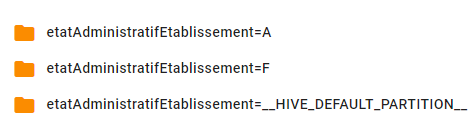

En théorie on doit : 
* gagner du temps si l'on utilise la varible etatAdministratifEtablissement.
* ne pas avoir trop dégrader les perfs sur le dataset global puisque la partition n'a pas fait explosé le nombre de fichier parquet par rapport au bloc s3 de 180Mo.

In [46]:
#on doit gagner du temps sur une partition
eaeDF = spark.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sireneEae.parquet")
eaeDF.createOrReplaceTempView("sirenepartition")
parqDFGroupBy= spark.sql(
    " select count(*) as total,activitePrincipaleEtablissement, word from ("
    " SELECT activitePrincipaleEtablissement,explode(split(denominationUsuelleEtablissement,' ')) as word "+
    " FROM sirenepartition where denominationUsuelleEtablissement is not null  and etatAdministratifEtablissement='A') "+
    " where length(word)>4"+
    " group by activitePrincipaleEtablissement,word order by total desc")
%time parqDFGroupBy.show()

+-----+-------------------------------+------------+
|total|activitePrincipaleEtablissement|        word|
+-----+-------------------------------+------------+
|16188|                         96.02A|    COIFFURE|
|11619|                         43.34Z|    PEINTURE|
| 9235|                         56.10C|       PIZZA|
| 8479|                         43.22A|   PLOMBERIE|
| 8299|                         96.02B|      BEAUTE|
| 8181|                         81.21Z|    SERVICES|
| 7542|                         68.31Z|  IMMOBILIER|
| 6617|                         43.99C|CONSTRUCTION|
| 6389|                         43.99C|  MACONNERIE|
| 6338|                         43.21A| ELECTRICITE|
| 6158|                         45.20A|      GARAGE|
| 6143|                         43.32A|  MENUISERIE|
| 5733|                         81.21Z|   NETTOYAGE|
| 4644|                         43.33Z|   CARRELAGE|
| 4250|                         70.22Z|     CONSEIL|
| 4197|                         47.73Z|   PHAR

In [47]:
#on doit pas avoir dégrader le traitement sur le dataset global
parqDFGroupBy= spark.sql(
    " select count(*) as total,activitePrincipaleEtablissement, word from ("
    " SELECT activitePrincipaleEtablissement,explode(split(denominationUsuelleEtablissement,' ')) as word "+
    " FROM sirenepartition where denominationUsuelleEtablissement is not null) "+
    " where length(word)>4"+
    " group by activitePrincipaleEtablissement,word order by total desc")
%time parqDFGroupBy.show()

+-----+-------------------------------+------------+
|total|activitePrincipaleEtablissement|        word|
+-----+-------------------------------+------------+
|21188|                         96.02A|    COIFFURE|
|15764|                         43.34Z|    PEINTURE|
|12196|                         56.10C|       PIZZA|
|11649|                         43.22A|   PLOMBERIE|
|11543|                         96.02B|      BEAUTE|
|10570|                         81.21Z|    SERVICES|
| 9278|                         68.31Z|  IMMOBILIER|
| 8605|                         43.99C|CONSTRUCTION|
| 8510|                         43.99C|  MACONNERIE|
| 8473|                         43.21A| ELECTRICITE|
| 7943|                         43.32A|  MENUISERIE|
| 7772|                         81.21Z|   NETTOYAGE|
| 7463|                         45.20A|      GARAGE|
| 6278|                         43.33Z|   CARRELAGE|
| 5650|                         43.99C|  ENTREPRISE|
| 5476|                         70.22Z|     CO

### Synthèse

Nous avons pu voir que les temps de traitements dépendent de :
1. Comment la donnée est enregistrée(format, granularité des blocs, partitionnement)
2. De paramètres de parallélisme des taches.
3. La capacité à l'utilisateur de comprendre ce qui se passe côté serveur et côté client pour ne ramener sur le client que le résultat.

Dans ce tutoriel, vous maitrisez votre cluster et votre fichier dans une stratégie de datalake d'entreprise:
- la diffusion des tables doit être réfléchie par une alimentation des tables/pipeline dans un format approprié au context du contenu.
- l'utilisateur accède aux tables sans en connaitre précisement le stockage.

In [48]:
spark.stop()

2022-03-29 10:18:15,576 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
